## Dado que ya acabamos la parte de los modelos y como pudimos ver la mayoria tienen unos desepeños excelentes dentro de sus paradigmas tanto en validacion y en testeo, decidimos decantarnos por XGBoost por lo mencionado al final del script pasado. 

## Con esto dicho en este script vamos a hacer la imputacion de caracteristicas, LIME y PDP en base a XGBoost

In [2]:
from sklearn.model_selection import train_test_split , cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression , Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler , RobustScaler , MaxAbsScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

base_final = pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\7 semestre\\Ia en economia\\Proyecto\\Base Final1.csv')
base_regresion = base_final[['Nmero Extranjeros', 'Homicidios', 'Hurtos',
       'Delitos Sexuales', 'Temperatura', 'Dolar',
       'Pib Ponderado', 'Distancia a accseos','importancia accesos',
       'Establecimientos de turismo', 'N Habitaciones', 'N Camas', 'Distancia al TOP',
       'Proxy Pobreza', 'Gasto Promedio Diario', 'Gasto Alojamiento Diario',
       'Gasto Transporte Diario', 'Gasto alimetos Diario',
       'Otros Gastos Diario', 'Gasto Promedio Viaje',
       'Gasto  Alojamiento Viaje', 'Gasto Transporte Viaje',
       'Gasto alimetos Viaje', 'Otros Gastos Viaje' , 'Inflacion' ,'Eventos', 'Area Urbana' , 'Area Rural' , 'Area Agua' , 'Nmero Vias']]

## **Importante**: El modelo se tenia que correr otra vez en este script para que quedara cargando en el entorno de pyhton. Pero es MUY RECOMENDABLE que no se vuelvan a correr estos codigos dado que el train test split dividira diferente la base de datos y pueden haber muchos problemas con las interpretaciones. Especialmente con LIME donde puede que en el conjutno de prueba no quede la fila que se esta seleccionado. Asi que lo mas recomendable es que no se vuelvan a correr estos codigos para asegurarnos que los resultados que se muestran sean los mismos que se interpretaron

In [140]:
x_labels = [i for i in base_regresion.columns][1:]
target = 'Nmero Extranjeros'

x = base_regresion.drop(columns=[target])
x_labels = [col for col in x_labels if col in x.columns]
y = base_regresion[[target]]

In [141]:

from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), x_labels),  
        ('poly', PolynomialFeatures(degree=1, include_bias=False), x_labels)
    ], 
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('regressor', XGBRegressor(n_estimators=41, max_depth=5 , objective='reg:squarederror'))])

pipeline.fit(X_train, y_train)

r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
mse_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
mae_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))

print(f"R2 scores para cada fold: {r2_scores}")

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)

print(f"R2 en el conjunto de prueba: {r2_test:.4f}")


R2 scores para cada fold: [0.98023407 0.98304956 0.97966066 0.98042918 0.98164749]
R2 en el conjunto de prueba: 0.9825


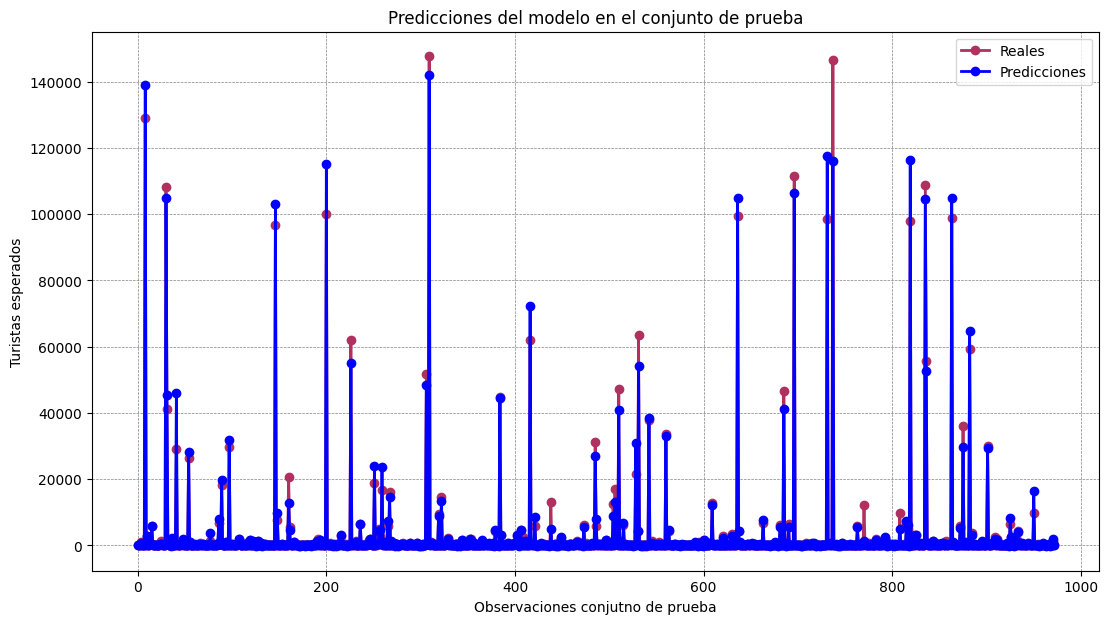

In [86]:

secuencia = np.arange(len(y_test))

plt.figure(figsize=(13, 7))
plt.plot(secuencia, y_test ,label="Reales",
         linewidth=2 , color='#B03060', marker='o')
plt.plot(secuencia, y_test_pred ,label="Predicciones",
         linewidth=2 , color='blue', marker='o')
plt.xlabel('Observaciones conjutno de prueba')
plt.ylabel('Turistas esperados')
plt.title('Predicciones del modelo en el conjunto de prueba')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## **Imputacion de caracteristicas**: Usando nuestro modelo de XGBoost en donde el R2 dio 0.9816, vamos a realizar la imputacion de caracteristicas 

In [15]:
r2 = 0.9816
dic = {}
l=[]

for i in range (X_test.shape[1]):
   for k in range(100):
      X_test_permutacion = X_test.copy()
      X_test_permutacion.iloc[: , i] = np.random.permutation(X_test_permutacion.iloc[: , i])
      y_permutacion_pred = pipeline.predict(X_test_permutacion)
      r2_permutacion = r2_score(y_test, y_permutacion_pred)
      r2_imputacion = r2 - r2_permutacion
      l.append(r2_imputacion)
   dic[X_test_permutacion.columns[i]] = l
   l=[]

Imputacion = pd.DataFrame(dic)
Imputacion

,Homicidios,Hurtos,Delitos Sexuales,Temperatura,Dolar,Pib Ponderado,Distancia a accseos,importancia accesos,Establecimientos de turismo,N Habitaciones,...,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,Inflacion,Eventos,Area Urbana,Area Rural,Area Agua,Nmero Vias
0,0.000271,0.026923,0.000630,0.001900,0.002552,0.019607,0.003589,0.000248,0.006781,0.000180,...,0.000019,0.000444,-0.000255,0.000296,0.005957,0.001646,0.246535,0.275692,0.105308,0.000058
1,-0.000683,0.031868,0.000444,0.002724,0.003665,0.018990,0.002652,0.000208,0.006532,0.000846,...,0.000019,0.000347,-0.000184,0.000121,0.006208,0.000798,0.228268,0.274621,0.123593,0.000125
2,0.000410,0.030638,0.000555,0.003011,0.003225,0.018746,0.001886,0.000111,0.007012,0.000550,...,0.000019,0.000476,-0.000167,0.000131,0.005292,0.000997,0.242648,0.259199,0.097291,0.000166
3,0.000285,0.030461,0.000941,0.001440,0.002901,0.018256,0.003052,0.000146,0.006772,0.000691,...,0.000019,0.000441,-0.000205,0.000240,0.002490,0.001247,0.201807,0.281182,0.131497,0.000116
4,0.000336,0.029307,0.000598,0.002200,0.001630,0.020171,0.002083,0.000251,0.005660,0.000063,...,0.000019,0.000399,-0.000235,0.000144,0.006879,0.002039,0.241519,0.240341,0.123630,0.000120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000276,0.027178,0.000532,0.002230,0.003656,0.019889,0.002288,0.000032,0.006519,0.000252,...,0.000019,0.000446,-0.000229,0.000229,0.006112,0.001016,0.264614,0.287583,0.120151,0.000034
96,0.000195,0.028452,0.000756,0.001630,0.001668,0.017302,0.003276,0.000173,0.006264,0.000304,...,0.000019,0.000655,0.000107,0.000252,0.006805,0.000820,0.275998,0.277642,0.127162,0.000291
97,0.000286,0.029304,0.000711,0.001921,0.002413,0.018794,0.003947,0.000198,0.007208,0.000103,...,0.000019,0.000461,-0.000163,0.000073,0.005577,0.001721,0.236060,0.257839,0.105246,0.000118
98,-0.000333,0.029752,0.000572,0.001528,0.002252,0.017509,0.003033,0.000199,0.006605,0.000151,...,0.000019,0.000316,-0.000198,0.000140,0.002571,0.001046,0.234503,0.265429,0.078132,0.000274


## Graficar la imputacion de caracteristicas 

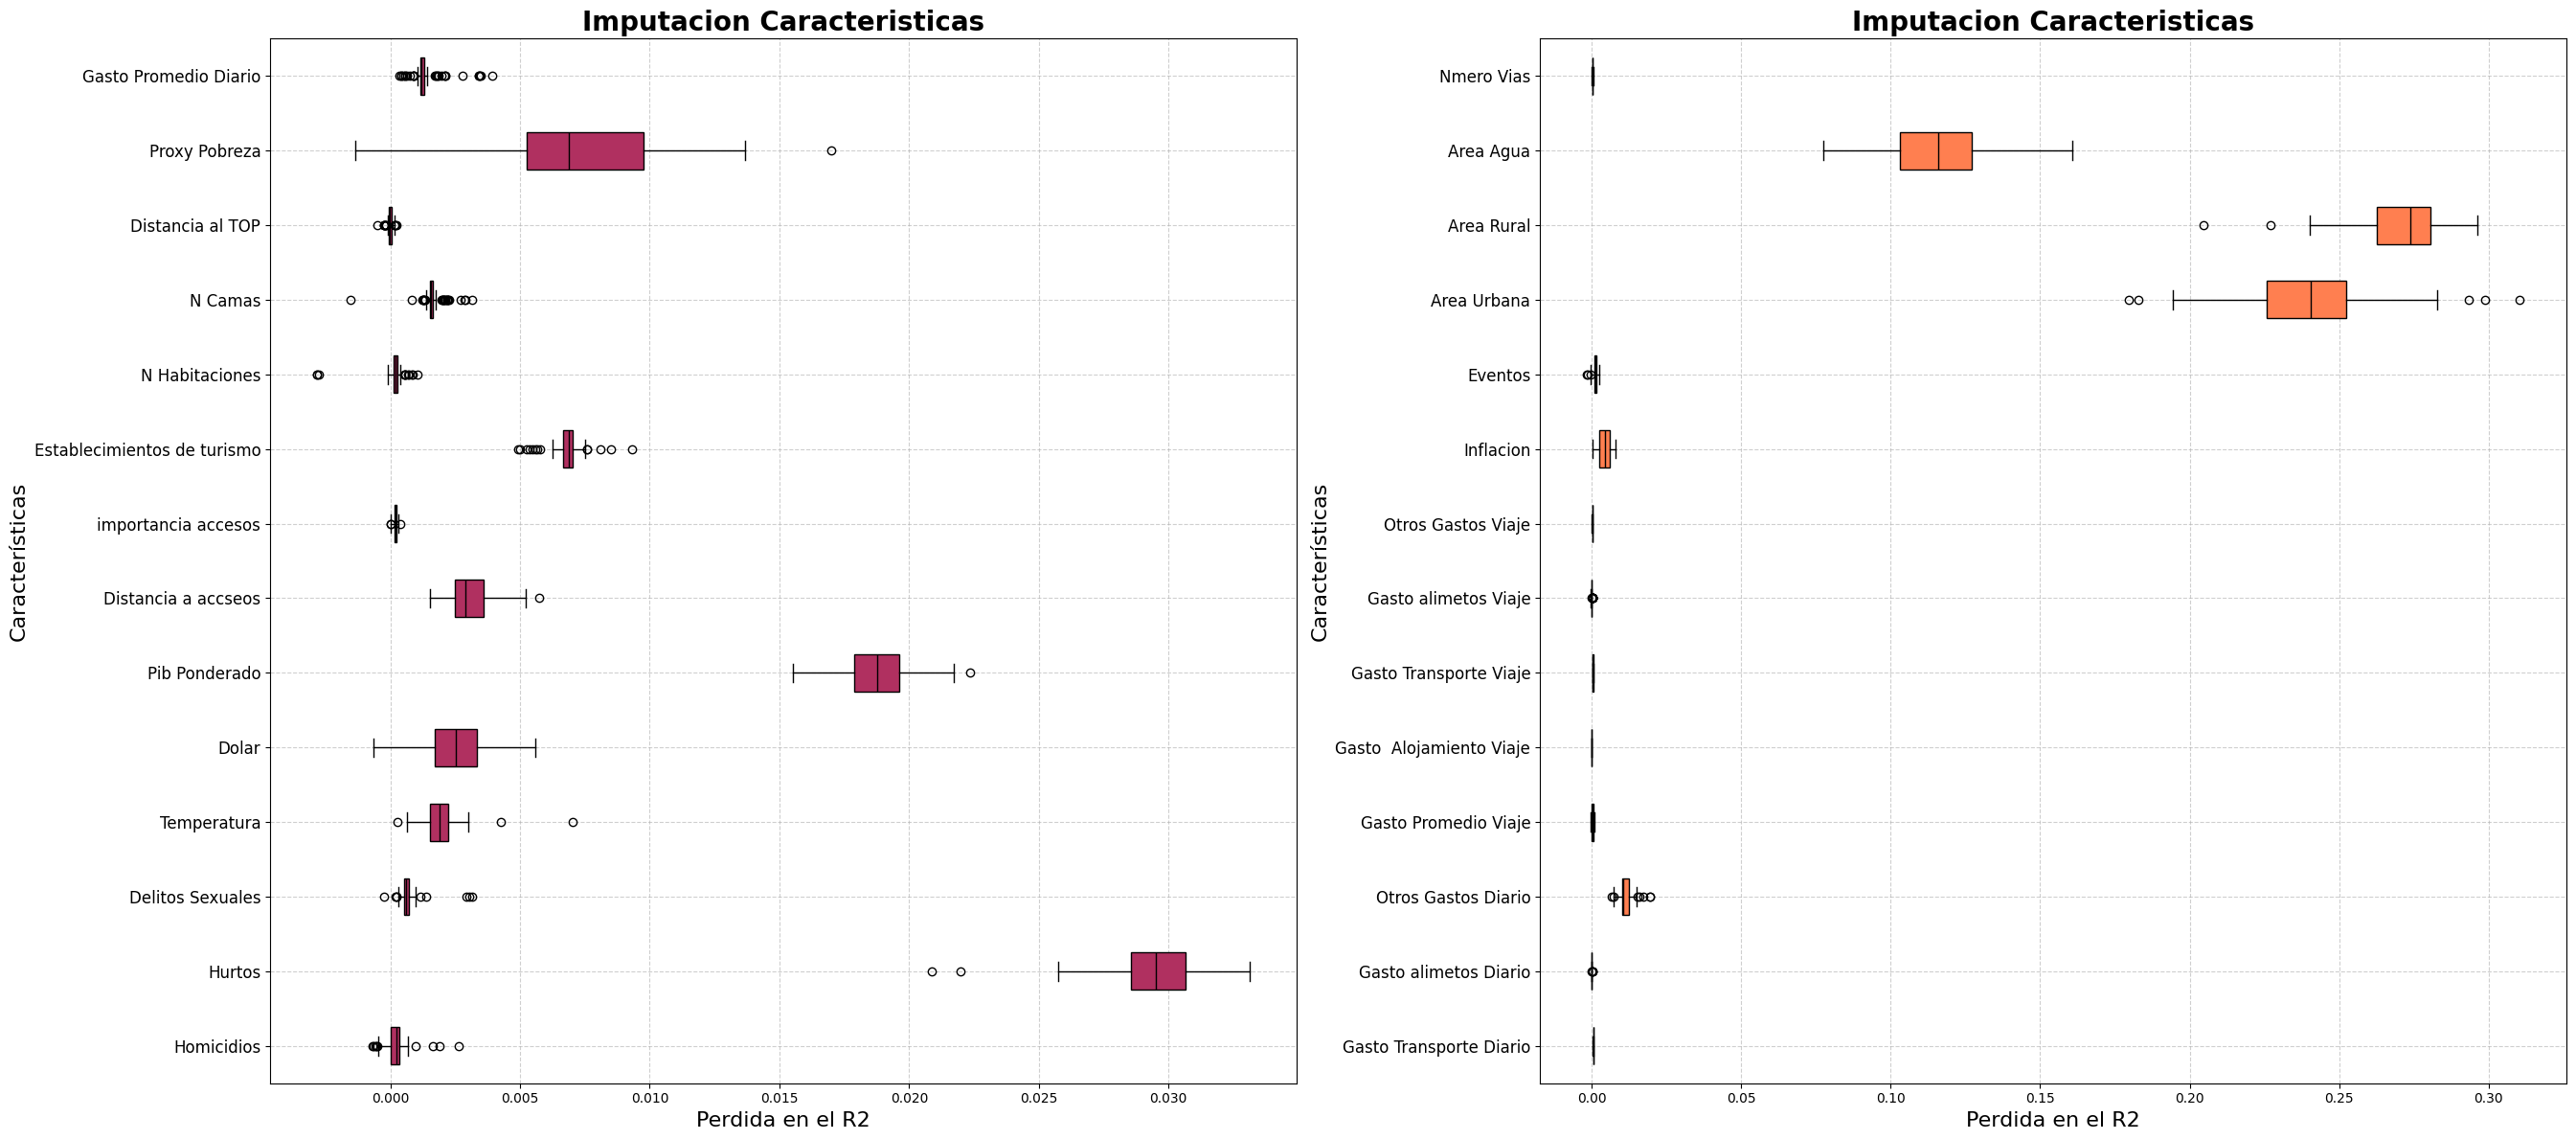

In [16]:
imputacion1 = Imputacion.iloc[: , 0:14]
imputacion2 = Imputacion.iloc[: , 15:]


fig, axes = plt.subplots(1, 2, figsize=(27, 12)) 


bp1 = axes[0].boxplot(imputacion1, vert=False, patch_artist=True,boxprops=dict(facecolor='#B03060'))

for median in bp1['medians']:
    median.set_color('black')  
axes[0].set_title('Imputacion Caracteristicas', fontsize=20, fontweight='bold')
axes[0].set_xlabel('Perdida en el R2', fontsize=16)
axes[0].set_ylabel('Características', fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_yticklabels(imputacion1.columns, fontsize=12)

bp2 = axes[1].boxplot(imputacion2, vert=False, patch_artist=True,boxprops=dict(facecolor='#FF7F50'))

for median in bp2['medians']:
    median.set_color('black') 
axes[1].set_title('Imputacion Caracteristicas', fontsize=20, fontweight='bold')
axes[1].set_xlabel('Perdida en el R2', fontsize=16)
axes[1].set_ylabel('Características', fontsize=16)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_yticklabels(imputacion2.columns, fontsize=12)

plt.tight_layout()
plt.show()

### **Interpretacion**: Con las imputaciones de caracteristicas podemos observar que de todas las variables solamente 3 son de suma importancia para el modelo: Area Urbana, Area Rural y Area de agua. Si el modelo perdiera alguna de estas variables perderia entre 10% y 25% de capacidad de capturar la varianza de la variable dependiente. Segun la grafica, la mas importante es el Area rural, seguida del area urbana y el area de agua. 
### Por otro lado podemos ver que el PIB y la cantidad de hurtos tambien logran ser importantes, haciendo que el modelo pierda entre 5 y 7 porciento de capacidad predictoria. 
### Por ultimo la mayoria de las variables no son tan significativas como se esperaria que fueran. Por ejemplo los establecimientos de turismo o los mismos costos de viaje de cada ciudad solo hacen perder el 1% de la capacidad predictoria del modelo. Los numeros de las vias principales de las vias tambien es una variable que es poco significativa pero se esperaria que no fuera asi. 

### Concluyendo: Esta grafica nos deja ver cuales son las variables para las cuales el modelo se apoyo y encontro los patrones mas claro (Siendo estas las diferentes areas y el PIB) mientras que otras variables son poco significativas al momento de predecir el numero de turistas 

## **LIME**: El conjunto de datos que estamos trabajando es pecular, en el sentido de que los datos atipicos son muy marcados pero son de suma importancia (en este conjunto los datos atipicos son las grandes ciudades como bogota, medellin...) dabido a  que si se quitan del dataframe todos los modelos predicen peor 

## En este sentido, vamos a hacer dos LIME uno seleccionado una de las grandes ciudades y viendo cuales son los efectos marginales (betas) que salen de esa fila. Y otra de una ciudad mas promedio, una ciudad mas pequeña, el fin de esto tambien es identificar cuales son las variables que mas influencian el turismo en las grandes ciudades y a las pequeñas, o si son las mismas.

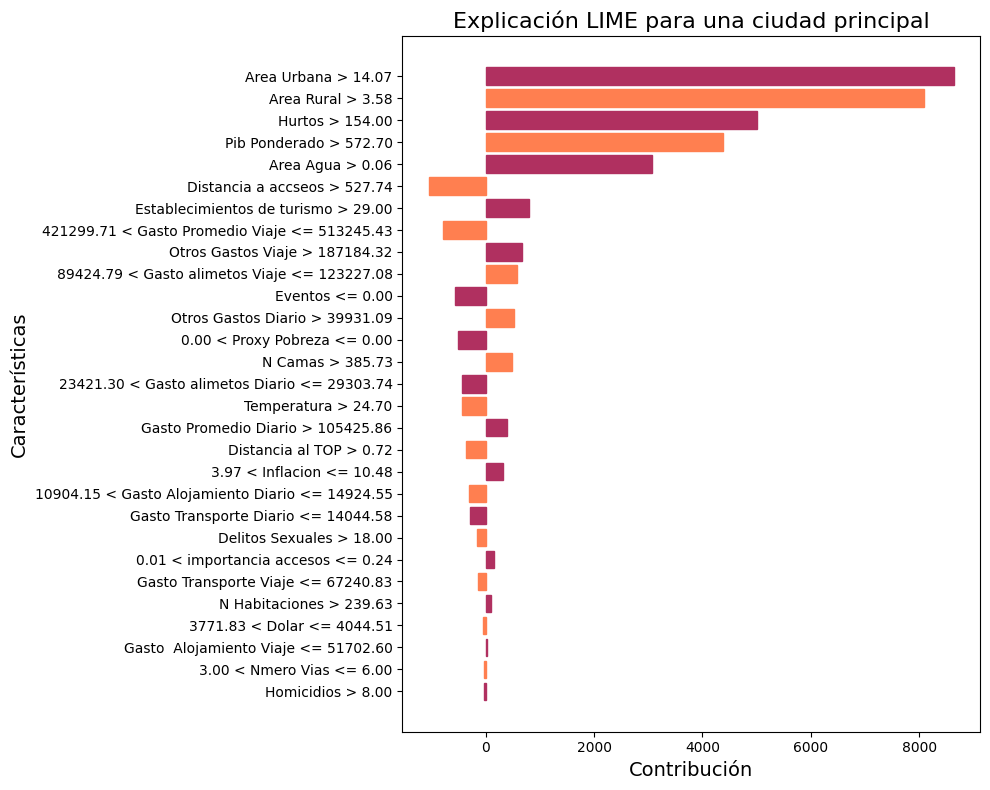

In [17]:
import xgboost as xgb
from lime import lime_tabular

feature_names = X_train.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    mode='regression'
)

i = 3279
instance = X_train.iloc[i].values


def predict_values(X):
    X_df = pd.DataFrame(X, columns=feature_names)
    return pipeline.predict(X_df)

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_values,
    num_features=29
)

fig = exp.as_pyplot_figure()
ax = fig.gca()
colors = ['#B03060', '#FF7F50']
bars = ax.patches
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)]) 

ax.set_title('Explicación LIME para una ciudad principal', fontsize=16)
ax.set_xlabel('Contribución', fontsize=14)
ax.set_ylabel('Características', fontsize=14)
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

### Interpretacion: Según la gráfica de LIME y para las grandes ciudades (Especialmente Bogota), el area urbana contribuye con un peso relativo de 0.6, lo que indica que, en la vecindad de esta predicción específica, tener un área urbana mayor a 14 km² es uno de los principales factores que aumentan el número de turistas predicho por el modelo. Por otro lado los hurtos son la segunda caracteristica con mayor contribucion a la prediccion. Los hurtos mayores a 155 tienen una contribución positiva en la predicción, posiblemente porque están correlacionados con el tamaño o la actividad de las ciudades, pero no significan causalidad directa. Tambien un PIB genera una contribucion en las interpretaciones de 0.45, haciendonos ver que en las ciuadades grandes el PIB es un factor directo de desarollo y capacidad para sustentar turismo en grandes escalas. 

### Con Lime podemos ver que algunas de las caracteristicas que dieron muy significativas en la imputacion, tambien lo son aca: Tanto el area de agua como el area rural tienen contribuciones mayores al 30% destacando su importancia para ciudades con diversidad geográfica y territorial. A diferencia de la imputacion de caracteristicas, en LIME los establecimientos de turismo tambien son uno de las principales caracteristicas que aumentan el numero de turistas en las ciudades mas grandes. 

### Por otro lado, tener pocas rutas de acceso principales en una ciudad grande, reduce la capacidad de prediccion del modelo, implicando la importancia en la conexion en las ciudades pirncipales. Asi como que el gasto en transporte que el gasto promedio diario sean mas elevados, hacen que se predigan menos turistas en una ciudad principal.Tambien que la importancia hacia los accesos (basicamente tener aeropuertos o puntos fronterizos muy visitados) sea muy baja reduce considerablemnte la cantidad de turistas.

### Finalmente, aunque las características con menor contribución no superan el 7% en importancia, es relevante señalar que una distancia a los puntos de acceso mayor a 527 km y la falta de eventos en la ciudad tienen un efecto negativo en la predicción del modelo, indicando que la accesibilidad y las actividades culturales siguen siendo factores relevantes en el turismo urbano. 

### **Conclucion**: Podemos decir que: el Área Urbana > 14 km² emerge como la característica con mayor impacto positivo, destacando la importancia de la infraestructura y los servicios asociados con áreas urbanas extensas. Los hurtos mayores a 155 también tienen una contribución relevante, posiblemente funcionando como un proxy del tamaño o actividad económica de la ciudad. Además, la presencia de establecimientos de turismo y características geográficas como el área de agua y el área rural refuerzan la predicción, resaltando la relevancia de la diversidad territorial y la capacidad turística. Por el contrario, características como pocas rutas de acceso principales, altos gastos promedio diarios, y una baja importancia de puntos de acceso (como aeropuertos o fronteras) afectan negativamente el número de turistas predicho, subrayando la necesidad de una buena conectividad e infraestructura accesible.

## LIME Para Una ciudad pequeña. 

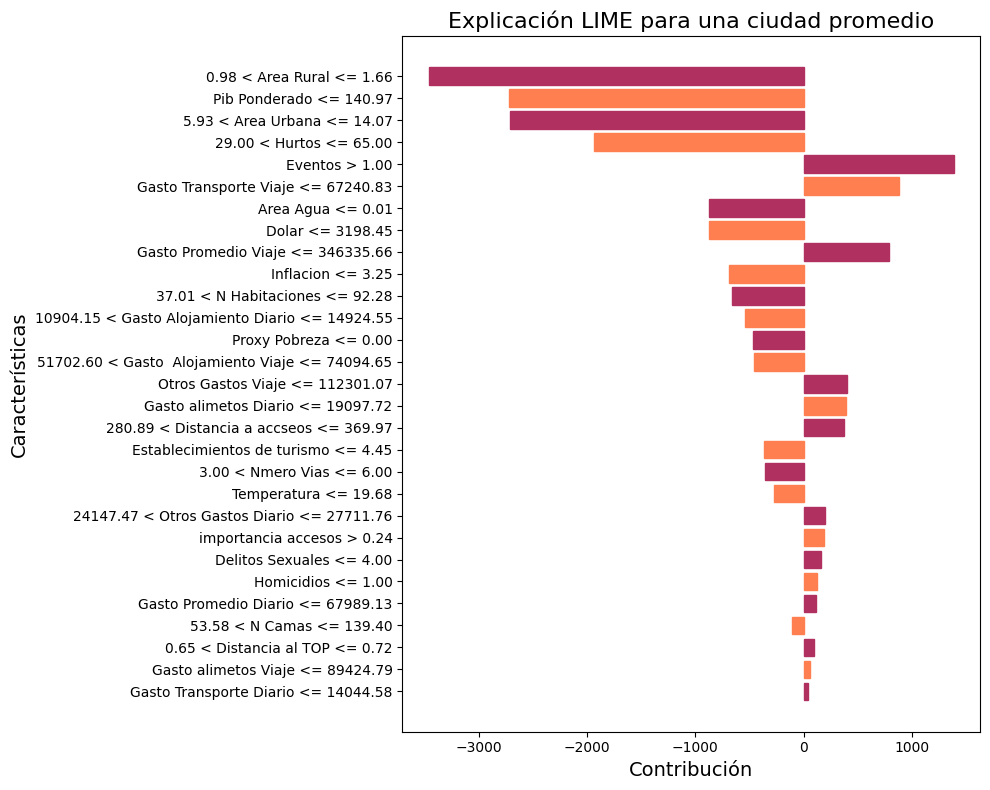

In [25]:
feature_names = X_train.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    mode='regression'
)
i = 549
instance = X_train.loc[i].values

def predict_values(X):
    X_df = pd.DataFrame(X, columns=feature_names)
    return pipeline.predict(X_df)

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_values,
    num_features=29
)

fig = exp.as_pyplot_figure()
ax = fig.gca()
colors = ['#B03060', '#FF7F50']
bars = ax.patches
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)]) 

ax.set_title('Explicación LIME para una ciudad promedio', fontsize=16)
ax.set_xlabel('Contribución', fontsize=14)
ax.set_ylabel('Características', fontsize=14)
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

### En la interpretación de LIME para una ciudad promedio, podemos observar una dinámica diferente respecto a lo que vimos en ciudades más grandes. El tamaño del área urbana, específicamente cuando está entre 0.98 y 1.16 km², es el factor que más contribuye negativamente a la predicción del número de turistas, lo que confirma que ciudades con áreas urbanas más pequeñas tienen menos capacidad para atraer grandes flujos turísticos. Aunque el impacto del área urbana es significativo, la magnitud de su efecto negativo es menor en comparación con ciudades más grandes.

### Por otro lado, la cantidad de eventos en la ciudad se destaca como la característica que tiene el mayor impacto positivo en la predicción del número de turistas. Esto subraya que, para ciudades promedio o pequeñas, los eventos atractivos son un motor clave para estimular el turismo, ya que compensan, en parte, la falta de tamaño e infraestructura que caracteriza a estas ciudades.

### Además, la mayoría de las características restantes tienen un efecto negativo sobre la predicción del número de turistas. Entre las más notables, encontramos que un PIB bajo reduce significativamente el flujo turístico, lo cual es esperable, ya que un PIB menor suele estar asociado con menos desarrollo en infraestructura turística y servicios. Otra característica importante es la distancia a los principales puntos de acceso internacional: cuanto mayor es esta distancia, menor es el flujo de turistas, ya que la accesibilidad es un factor crítico para ciudades promedio. Asimismo, el costo del transporte también actúa como una barrera que disminuye la predicción de turistas.

### Finalmente, características que tienen un impacto positivo incluyen la presencia de establecimientos de turismo, que, aunque con menor magnitud que los eventos, son importantes para atraer visitantes. Esto refuerza la necesidad de invertir en infraestructura turística local y de garantizar precios accesibles tanto en transporte como en alojamiento, con el objetivo de maximizar el atractivo turístico de estas ciudades.

### **CONCLUCION FINAL**: En ciudades grandes como Bogotá, el principal determinante del turismo es el tamaño del área urbana. Un área urbana grande contribuye significativamente a la predicción del número de turistas, ya que está asociado con una mayor oferta de infraestructura, servicios turísticos y capacidad para recibir visitantes. En contraste, las características negativas incluyen altos costos de transporte y gasto promedio diario, así como pocos puntos de acceso internacional. Esto sugiere que, aunque las ciudades grandes tienen una capacidad inherente para atraer turistas debido a su tamaño y recursos, los costos de viaje y la conectividad siguen siendo barreras importantes que podrían limitar su potencial. Por otro lado,En ciudades promedio, el tamaño del área urbana es el principal factor que contribuye negativamente a la predicción del número de turistas. A diferencia de las ciudades grandes, donde el tamaño del área urbana es un motor positivo, aquí se convierte en una limitación. Sin embargo, la cantidad de eventos emerge como el principal factor positivo, lo que resalta que los eventos atractivos pueden ser una forma efectiva de compensar las limitaciones estructurales de las ciudades más pequeñas. 

### Estrategias para fomentar el turismo: Promover eventos locales, Mejorar la conectividad hacia las ciudades mas pequeñas, Desarrollar infraestructura turística (esto no solo es hoteles, sino toda empresa que su fin sea el turismo) y Reducir costos para los visitantes.

# PDP (Partial Dependance Plot)

In [93]:
def PDP(X , col , inicio , final , cantidad):
    dic={}
    valores = np.linspace(inicio, final, cantidad)
    for i in valores:
        X_temp = X.copy()
        X_temp[col] = i
        y_PDP = pipeline.predict(X_temp)
        media = y_PDP.mean()
        dic[i] = media
    x = list(dic.keys())
    y = list(dic.values())

    plt.figure(figsize=(15, 4))
    plt.plot(x,y, label=col, 
         linewidth=2 , color='#B03060')
    cuartiles_a_mostrar = x[::(int(len(valores)/20))]
    plt.xticks(cuartiles_a_mostrar, rotation=45)
    plt.xlabel("Variaciones margianles")
    plt.ylabel('Cantidad de turistas predecidos')
    plt.title(f'Variaciones marginales de la variable: {col}')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=11)

## PDP para Area Rural

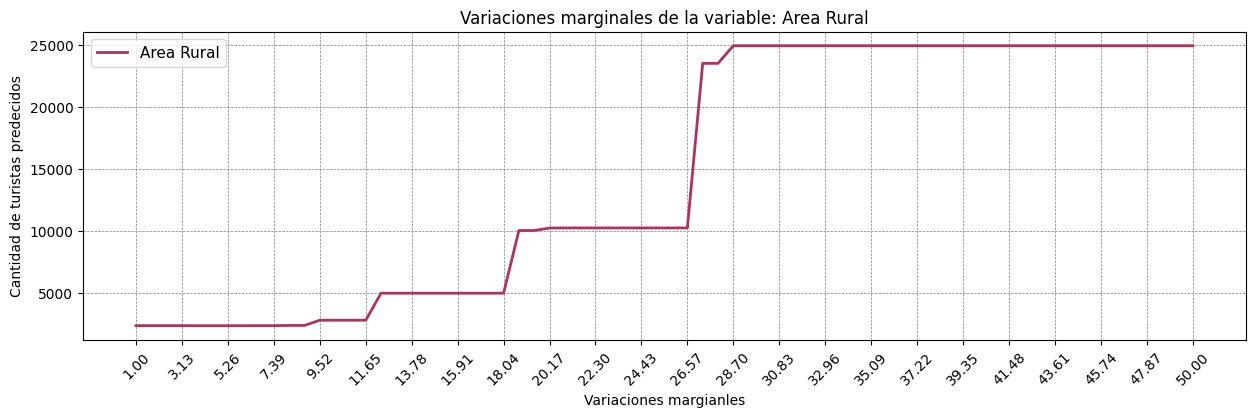

In [94]:

PDP(X_test, 'Area Rural' , 1 , 50 , 70)

### Interpretacion: Con esta PDP podemos observar que cuando el area rural supera los 18 km2 el incremento en turistas es absoluto. Pasando de 5000 mil turistas a 10000; a los 26km2 mas tiene su pico maximo de crecimiendo pasando de 10k a 25k. Esto lo podriamos asociar con la frontera que separa las ciudades grandes, que tienen grandes parques o zonas verdes y por esto reciben la mayor cantidad de turistas con las que no.

## PDP para Area Urbana 

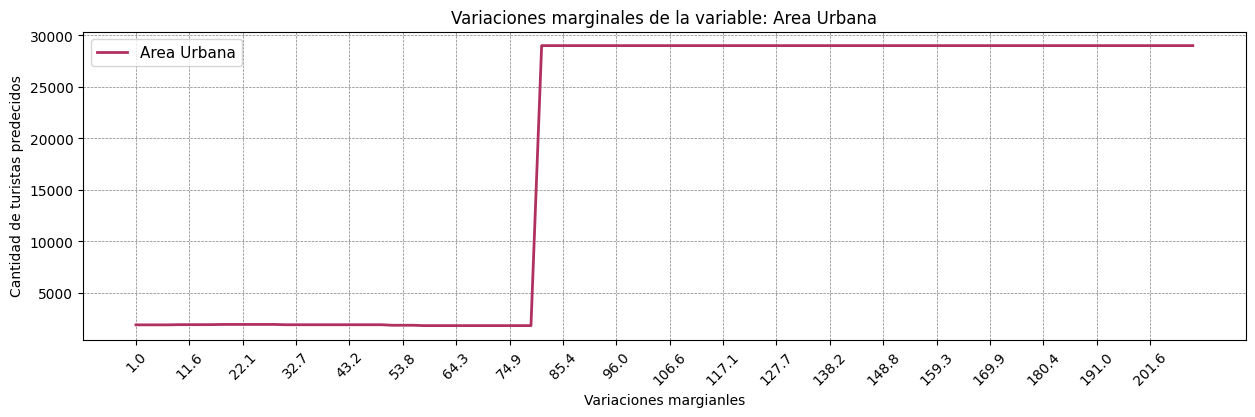

In [95]:
PDP(X_test, 'Area Urbana' , 1 , 210 , 100)

### Interpretacion: A diferencia de el area rural, las contribuciones marginales que nos arroja la PDP para esta variable son mas drasticas. Podemos ver que existe un punto de inflexion (78km2) para el cual el numero de turistas cambia drasticamente de 3000 a 35000. Con esto podemos ver que el punto de inflexion en el cual una ciudad empieza a ser atractiva por los turistas en terminos de ifrastructura, conexion y tamaño es despues de los 78km2

## PDP para PIB

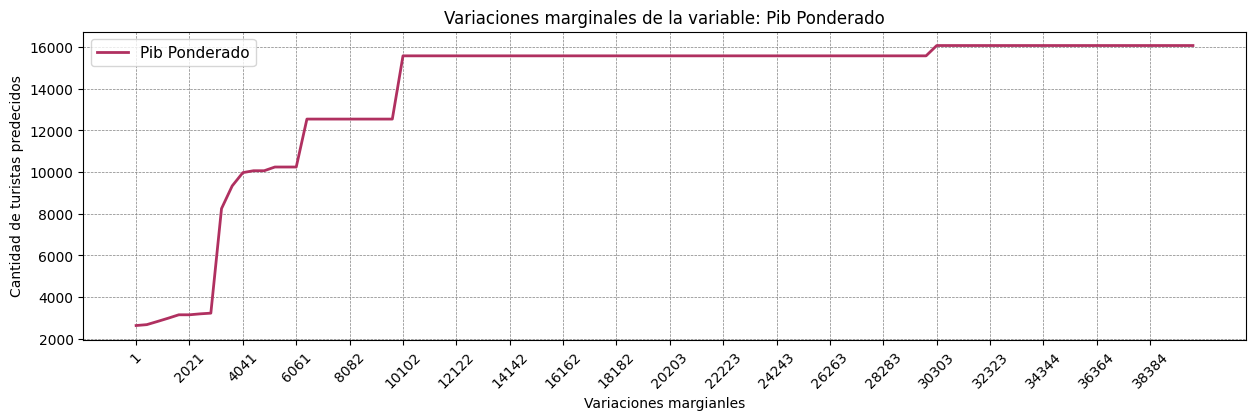

In [96]:
PDP(X_test, 'Pib Ponderado' , 1 , 40000 , 100)

### Interpretacion: Por otro lado de las contribuciones marginales del PIB podemos ver que siguen una tendencia muy parecida a las de area rural y area urbana. Mientras mas crece el PIB especialemnte cuando pasa de los 9000 mil millones de PIB anuales. EL flujo de turistas aumenta significativamete. En las interprtaciones pasadas que hemos visto, hemos podemos concluir que el tamaño de la ciudad es el factor mas importante que atrae turistas, lo que le aporta a este analisis las graficas PDP, es que ahora podemos saber que es grande y desde que punto las ciudades empiezan a considerarse grandes para atraer tuistas. Hemos concluido que es ciudades con mas de 70km2 de area urbana y mas de 9000 mil millones de PIB anuales.

## PDP para Temperatura

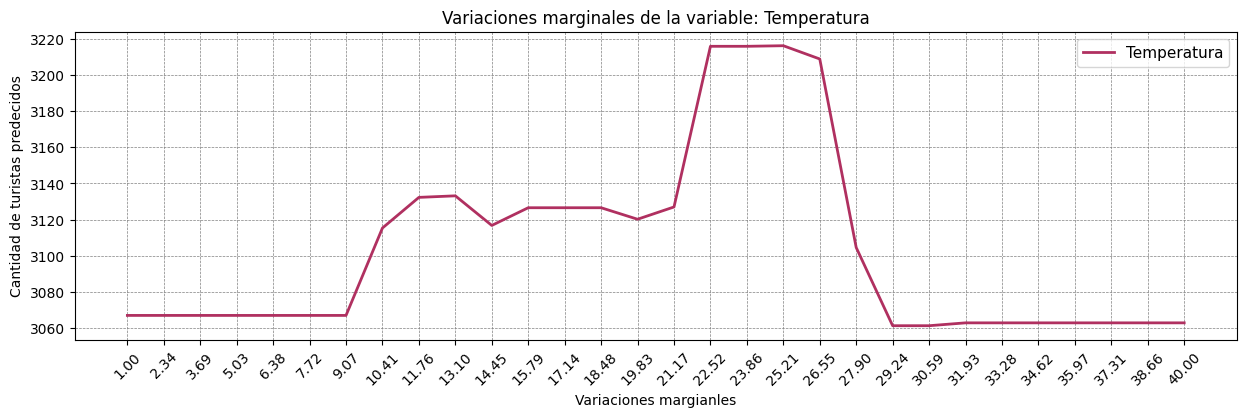

In [103]:
PDP(X_test, 'Temperatura' , 1 , 40 , 30)

### Interpretacion: Esta PDP es curiosa, por que nos permite ver que las temperaturas mas deseadas por los turistas esta entre los 21 y 25 grados celcius. Pero podemos ver que las temperaturas extrmas (mas de 30) no son para nada desadas e incluso se prefieren temperaturas cercanas a los 10 grados antes que el calor extremo. 

## PDP para Establecimientos de turismo

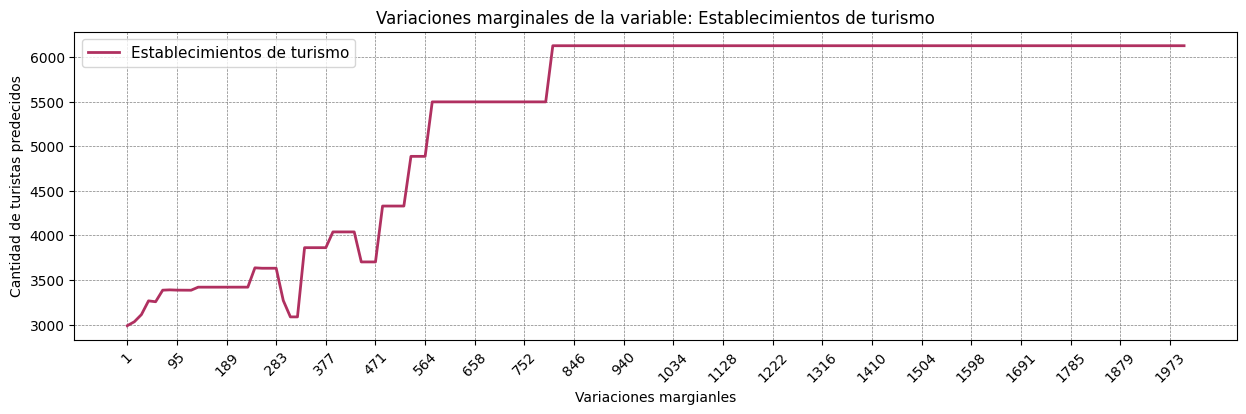

In [104]:
PDP(X_test, 'Establecimientos de turismo' , 1 , 2000 , 150)

### Interpretacion: Esta grafica tambien es util, dado que gracias a LIME sabemos que el numero de establecimientos de turismo es un factor que se puede potenciar para atraer mas turistas en ciudades pequeñas y dado que simplemente hacer que una ciudad crezca en PIB y en area urbana no es una solucion valida para tratar de ayudar a las ciudades pequeñas. Se puede potenciar la creacion de establecimientos de turismo, especialmente podemos ver que cuando estos pasan de 450 el aumento en turistas extranjeros es absoluto. Esto podria ser una buena iniciativa por parte del gobierno mas que apuntarle a amentar los km2 de una ciudad

## PDP para Distancia al TOP

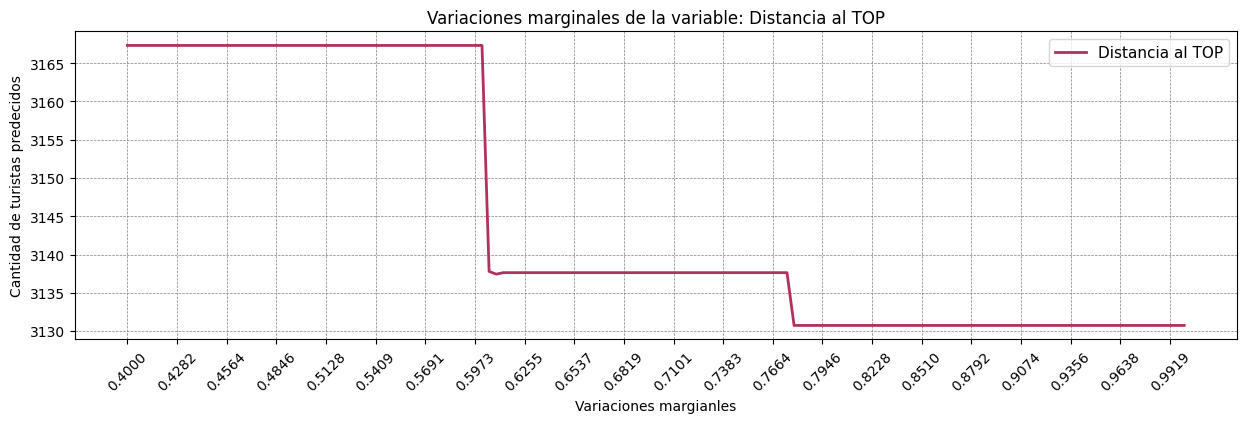

In [105]:
PDP(X_test, 'Distancia al TOP' , 0.4 , 1 , 150)

### Interpretacion: Cone esta PDP podemos ver que entre mas lejos esten las ciudades de los sitios turisticos mas recomendados por TripAdvisor y paginas de google, los turistas que puede llegar a recibir la ciudad bajan significativamente. Especialmente, cuando esta distancia sobrepasa los 0.59 los turistas extranjeros caen de manera estrepitosa.

## PDP para los Homicidios 

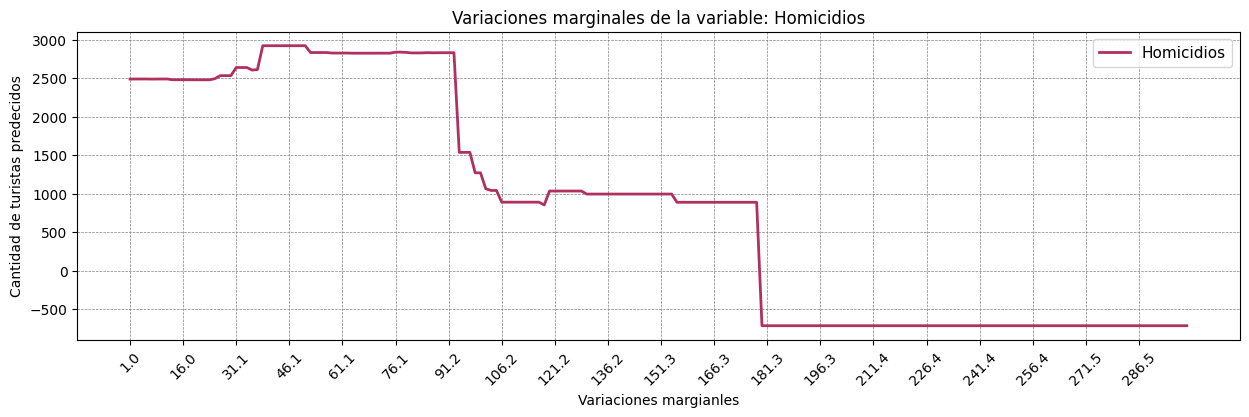

In [142]:
PDP(X_test, 'Homicidios' , 1 , 300 , 200)

### Interpretacion: Con la PDP de homicidios, podemos ver que a medida que estos aumentan los turistas extranjeros disminuyen, esto es debido a la percepcion de riesgo que se tiene sobre la ciudad cuando la tasa de homocidios es tan alta, tambien influye mucho las advertencias que generan los paises exteriores sobre una zona del pais (como usualmente lo hace USA) cuando la tasa de homicidios es alta. Con esto efectivamente podemos concluir que la relacion entre turismo y turismo extranjero es inversa y esta fuertemente marcada.  

## PDP para Gasto Promedio Viaje 

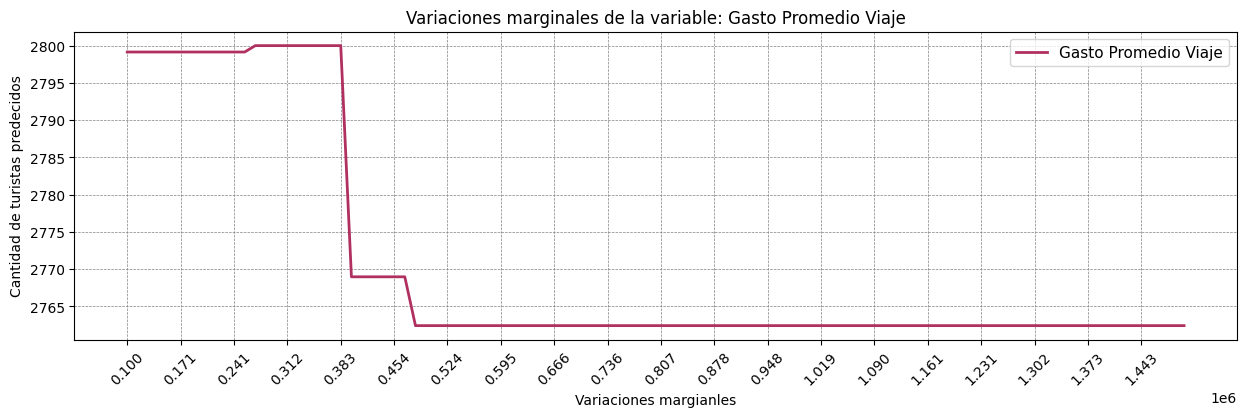

In [120]:
PDP(X_test, 'Gasto Promedio Viaje' , 100000 , 1500000 , 100)

### Interpretacion: Esta interpretacion es bastante evidente, a medida que aumenta el precio del viaje promedio en la ciudad, se esperan recibir menos turistas. 

## PDP para el Dolar

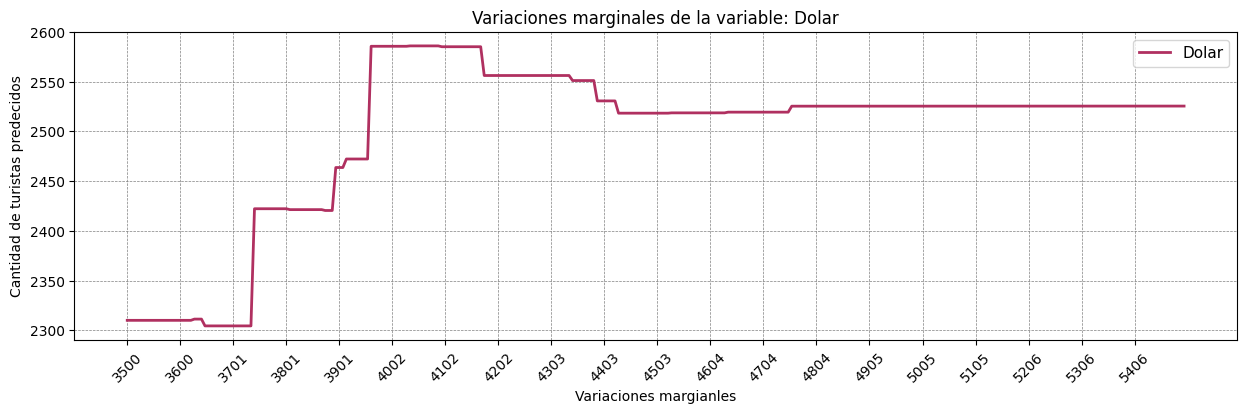

In [137]:
PDP(X_test, 'Dolar' , 3500 , 5500 , 300)

### Interpretacion: Con esta PDP podemso ver que a medida que aumenta el precio del dolar se espera recibir mas turistas extranjeros. Esto basicamente ocurre por que la mayoria de los turistas que vienen a colombia (como pudimos ver en las graficas presentadas) son de estados unidos y para ellos les es mas bartato viajar a colombia cuando el dolar esta mas caro. Se favorcen de la devaluacion del dolar. 

## PDP para Cantidad de eventos

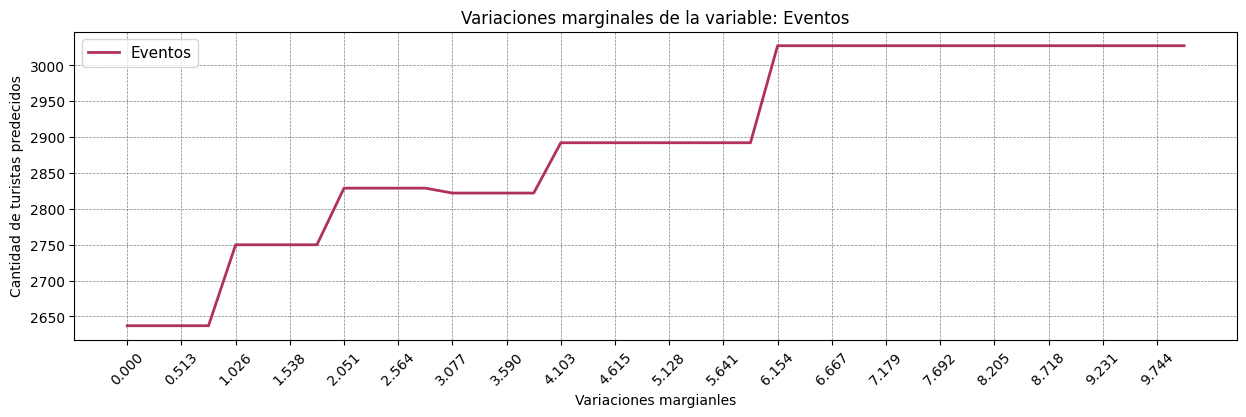

In [122]:
PDP(X_test, 'Eventos' , 0 , 10 , 40)

### Interpretacion: Esta es otra PDP de suma importancia, por complementa bien el analisis de LIME de las pequeñas ciudades. Como pudimos ver en LIME los eventos son una de las caracteristcas que puede ayudar a aumentar el flujo de turistas hacia las pequeñas ciudades y con esta PDP podemos complementar que despues de 4 eventos al mes el numero de turistas aumenta bastante y aunque este aumento no es tan grande como el que produce el de area urbana o el PIB. Estos 2000 mil turistas extra puede ayudar de gran forma a la economia de un pueblo peuqueño generando desarrollo economico en ultimas.

## PDP para el numero de vias principales 

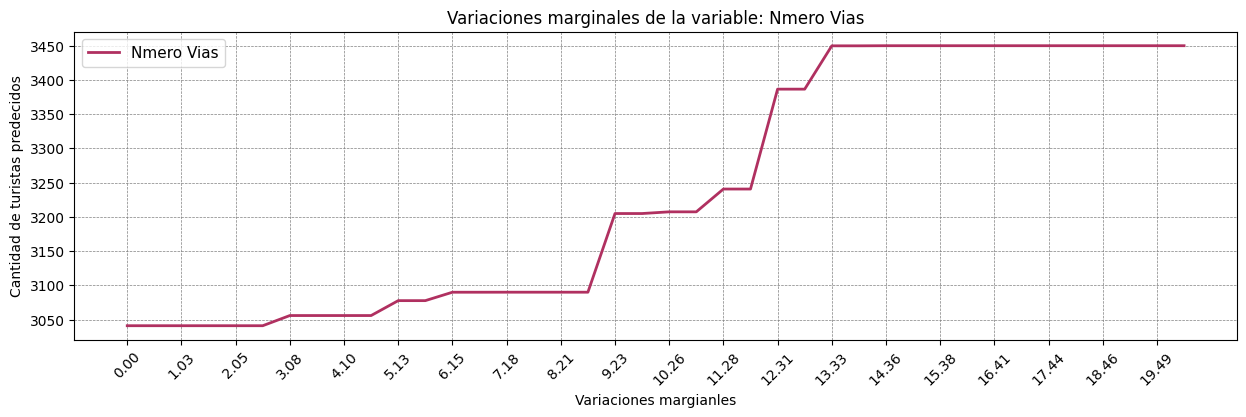

In [110]:
PDP(X_test, 'Nmero Vias' , 0 , 20 , 40)

### Interpretacion: En esta ultima PDP podemos ver que existe una relacionm positiva entre el numero de turistas y la cantidad de vias principales que la ciudad tienen cerca. Esto debido a que la conexion es un factor importante en la mente de un turista extranjero al momento de escoger a que ciudad de colombia viajar. Tambien se podria fomentar el turismo hacia los peuqeños pueblos haciendolos mas accesibles desde todas las posibles zonas y puntos de acceso del pais. 

## Conclucion final: El turismo en Colombia está influenciado por una diversidad de factores que varían en importancia dependiendo del tamaño y las características de cada ciudad. En las ciudades grandes, como Bogotá, el tamaño del área urbana (mayor a 70 km²) y un PIB significativo (más de 9000 mil millones anuales) son los principales determinantes del flujo turístico. Estas características están asociadas con una infraestructura más desarrollada, una mayor capacidad de servicios turísticos y una oferta más amplia para los visitantes. Sin embargo, estos beneficios pueden verse limitados por barreras como los altos costos de transporte, el gasto promedio diario elevado y la falta de conectividad con puntos de acceso internacionales, factores que reducen el atractivo de estas ciudades para turistas potenciales.

## En las ciudades pequeñas y promedio, las dinámicas son diferentes. Aquí, los eventos locales se posicionan como un motor clave para estimular el turismo, ya que pueden compensar las limitaciones relacionadas con el tamaño e infraestructura. Organizar más de cuatro eventos mensuales genera un impacto positivo en el flujo turístico y contribuye al desarrollo económico local. Además, el aumento en el número de establecimientos turísticos, especialmente al superar umbrales de 450 establecimientos, también es crucial para atraer visitantes. La conectividad mediante vías principales y la proximidad a puntos de interés turístico son igualmente importantes, ya que la accesibilidad es un factor decisivo para los turistas al elegir su destino.

## Otros elementos tienen un impacto transversal. La diversidad territorial, con áreas rurales y acuáticas, contribuye significativamente al turismo en regiones con una geografía variada, especialmente cuando estas áreas superan ciertos tamaños clave. Factores como la temperatura también influyen: las temperaturas entre 21 y 25 grados Celsius son las más atractivas para los turistas, mientras que los extremos (como temperaturas superiores a 30 grados) tienden a ser menos deseables. La seguridad también desempeña un papel importante, ya que las altas tasas de homicidios afectan negativamente al turismo debido a la percepción de riesgo y las advertencias internacionales. En contraste, un dólar fuerte favorece la llegada de turistas extranjeros, especialmente de Estados Unidos, al hacer más competitivos los costos de viajar a Colombia.

## En conclusión, es esencial implementar estrategias diferenciadas para fomentar el turismo en Colombia según el tipo de ciudad. En las grandes ciudades, es prioritario mejorar la conectividad internacional, reducir los costos para los visitantes y fortalecer la infraestructura para superar las barreras actuales. En las ciudades pequeñas, se deben promover eventos locales, desarrollar establecimientos turísticos y mejorar la accesibilidad mediante inversiones en vías principales. Estas acciones permitirían no solo aumentar el flujo turístico, sino también generar un impacto económico positivo, impulsando un desarrollo sostenible que aproveche las fortalezas únicas de cada región. Al abordar tanto los desafíos como las oportunidades en cada contexto, Colombia puede consolidarse como un destino turístico competitivo y diverso.

# Autores: Pablo Reyes y Victoria Vargas 
# Universidad Externado de Colombia 
# Revisado: Daniel Godoy 